# 7. Handling Histogram data with CAQL

CAQL supports histogram value types.

Histograms give you a powerfull way to aggregate data while keeping enough information to derive robust statistics.

## Robustness vs. Mergability

- Robust statistics are resistent to a small number of large outliers.

- Mergable statistics allow aggregation.

Both are desireable properties, but it seems you can only get one of them.

- mean, stddev, count are mergable
- median, IQR, percentiles are robust

Histograms give you both!

In [2]:
%run preamble.py
%matplotlib inline

## Histograms allow you to monitor high frequency APIs

Blog post eBPF: https://www.circonus.com/2018/05/linux-system-monitoring-with-ebpf/

## Fetching Histogram data

Histogram data can be fetch using the following CAQL functions:

* metric:histogram(uuid, name)
* search:metric:histogram(query)
* find:histogram(name, query)

**CAVEAT:** The Circonus Graphing UI, only supports rendering a single histogram output metric. Only the first output will be shown.

**HINT:** You can use `histogam:merge()` to merge all histogram output streams into a single histogram.

Demo: https://demo.circonus.com/trending/graphs/edit/52b1304b-4fc9-4c1c-b704-ad892846c002

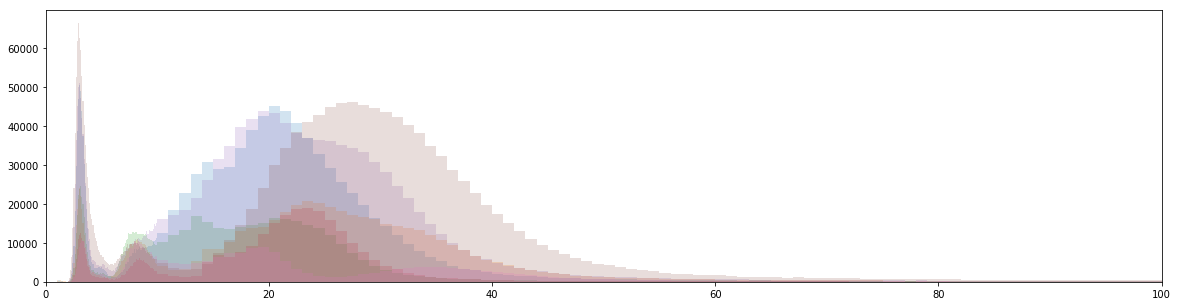

In [21]:
ax = caql_hist_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")

''', datetime(2018,1,1), 60*60*24, 7).set_xlim(0, 100)

## Creating histograms from numeric data

* `histogram(){...}`

Examples:

* Quick histogram for testing: ```histogram{1,2,3}```

* Convert search results into a histogram:
  ```
  search:metric:average("(tag:dc:us1) (tag:service:www) (metric_name:cpu`idle)") 
  | histogram()
  ```  
  This can be used in CAQL checks, to give quick access to a service wide context.

# Basic Histogram Transformations

* histogram:count() -- count number of samples in histogram
* histogram:count_below(y1,y2,...) -- count number of samples below provided thresholds
* histogram:precentile(p1,p2,...) -- compute percentiles of data in histogram

### Percentile View

(0, 100)

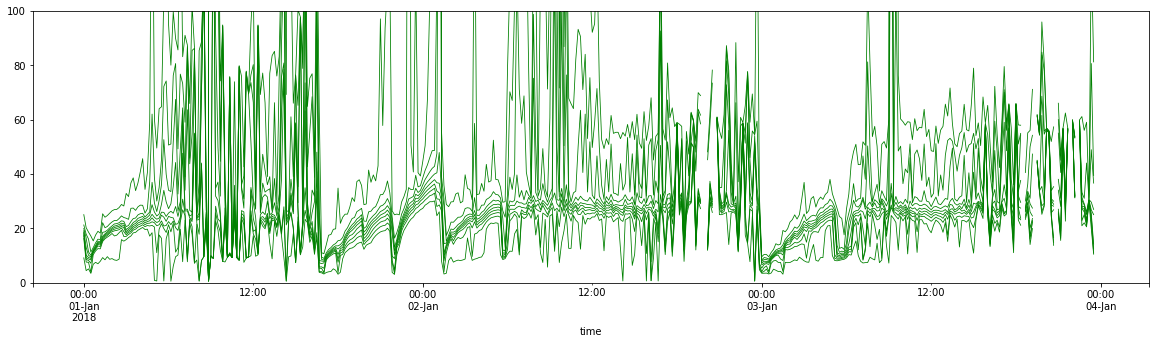

In [18]:
caql_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")
| histogram:percentile(10,20,30,40,50,60,70,80,90)

''', datetime(2018,1,1), 60*10, 60 * 24 * 3/10, color="green").set_ylim(0,100)

### Latency Band View

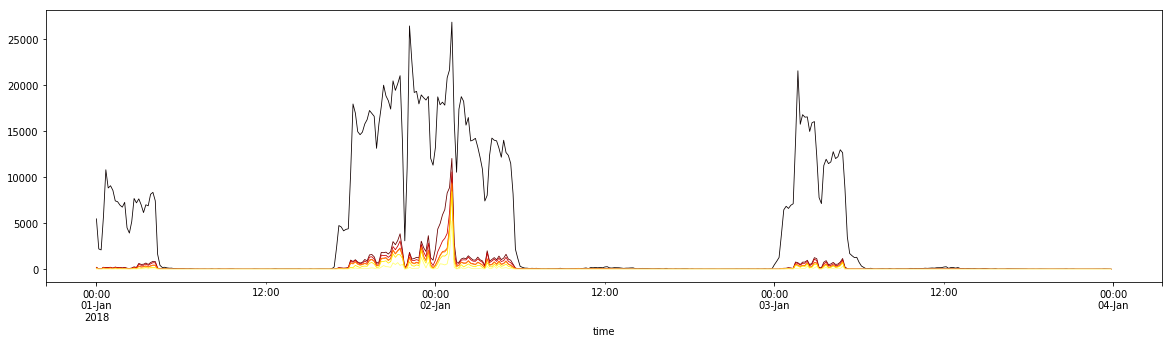

In [41]:
caql_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")
| histogram:count_above(0,40,50,90,100,200,1000,10000)

''', datetime(2018,1,1), 60*10, 60 * 24 * 3/10, cmap="hot")

### Summary Statistics

- histogram:mean()
- histogram:stddev()

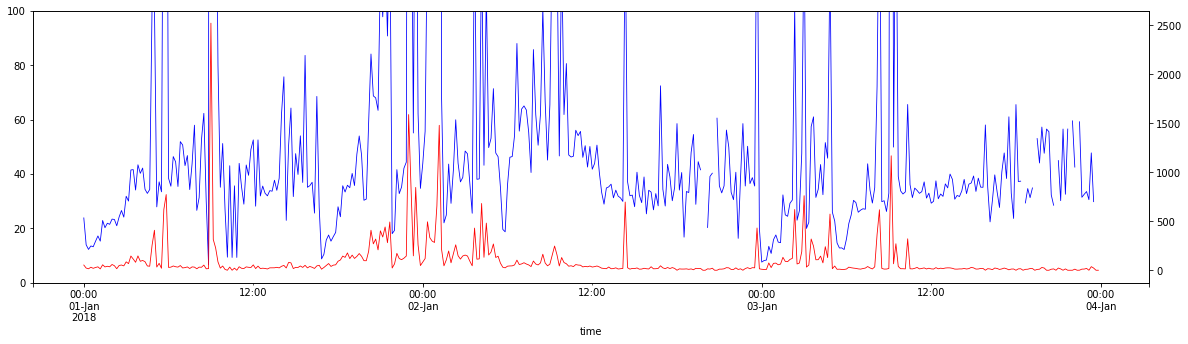

In [68]:
M=caql_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")
| histogram:mean()

''', datetime(2018,1,1), 60*10, 60 * 24 * 3/10, color="blue")
M.set_ylim(0,100)
caql_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")
| histogram:stddev()

''', datetime(2018,1,1), 60*10, 60 * 24 * 3/10, color="red", ax=M.twinx())

### Calculate the IRQ

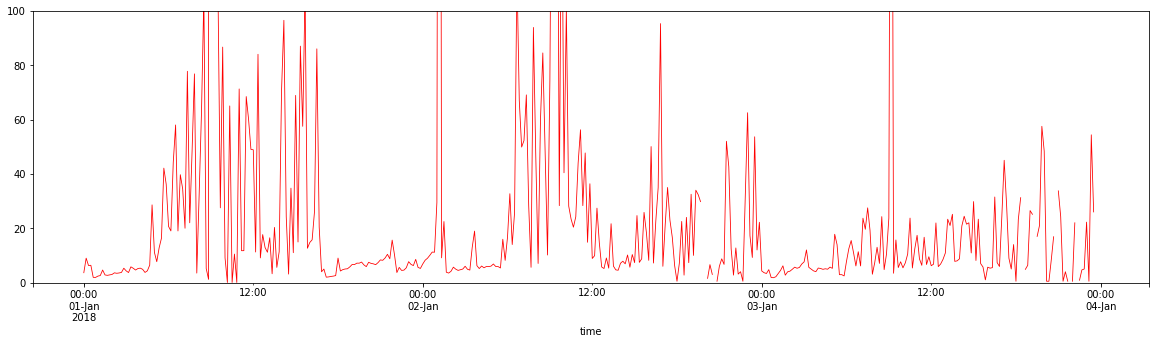

In [8]:
M=caql_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")
| histogram:IQR()

''', datetime(2018,1,1), 60*10, 60 * 24 * 3/10, color="red").set_ylim(0,100)

## Aggregating Histograms

- histogram:merge{} -- allows you to aggregate data across metrics.

- histogram:rolling{} -- aggregate data across time in a rolling window
- histogram:window{} -- aggregate data across time in windows
    
**CATCH:** It's histogram:window not window:histogram

**TODO:** Optimize internal processing of histogram:window(), histogram:rolling().

**TODO:** Allow time-zone alignment of histogram:window()

## Application: Compute Accurate Daily Percentiles

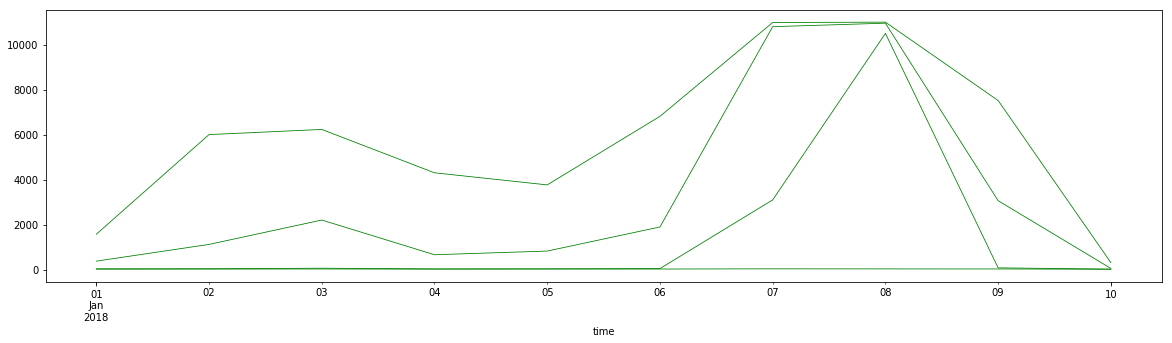

In [63]:
caql_plot('demo','''

metric:histogram("14ab8f94-da3d-4047-f6fc-81cc68e9d4b5", "api`GET`/getState")
| histogram:window(1d)
| histogram:percentile(50,90,99,99.9)

''', math.floor(datetime(2018,1,1).timestamp()/60/60/24)*60*60*24, 60 * 60 * 24, 10, color="green")

This might not look like much, but this type of statistics is pretty hard to get with other tools.

Variant:
```
search:metric:histogram("(tag:service:www) (metric_name:/`latency)")
| histogram:merge()
| histogram:window(1d)
| histogram:count_below(10,1000,10000)
```